In [1]:
import os.path
from scipy import *
import scipy as sp
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import math as math
from math import factorial as fact

sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 128
refRatio = 2
c = 1.
CFL = 0.5
nt = 1
RK = 1
deriv = 'CD'
order = 1

In [3]:
omega = BT.Grid(nh)
# finehalf = list(np.arange(int(nh / refRatio)) + int(nh / refRatio))
# omega.AddPatch(refRatio, finehalf)
nh_min = omega.nh_min
waves = WT.MakeWaves(omega)
print(waves)

[[ 1.          0.02453876  0.99959845  0.04904797  0.99839439  0.07349811  0.99638956  0.09785976  0.99358685  0.12210366  0.98999032  0.14620071  0.98560515  0.17012208  0.98043768  0.19383918  0.97449536  0.21732378  0.96778676  0.24054802  0.96032155  0.26348445  0.95211046  0.28610607  0.94316532  0.3083864   0.93349897  0.33029951  0.92312528  0.35182002  0.91205911  0.37292323  0.90031632  0.39358506  0.88791367  0.41378216  0.87486887  0.4334919   0.8612005   0.45269244  0.84692799  0.47136274  0.83207161  0.4894826   0.81665238  0.50703269  0.80069212  0.52399458  0.7842133   0.54035076  0.76723913  0.55608469  0.7497934   0.57118078  0.73190053  0.58562448  0.71358549  0.59940221  0.69487374  0.61250146  0.67579123  0.62491078  0.65636432  0.63661977  0.63661977  0.64761913  0.61658467  0.65790063  0.59628638  0.66745718  0.57575253  0.67628278  0.55501094  0.68437255  0.53408958  0.69172273  0.51301654  0.69833068  0.49181995  0.70419489  0.47052798  0.70931496  0.44916875  0

In [5]:
def ModeProp(omega, nt, c, CFL, deriv, RK, order):
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    nh_max = omega.nh_max
    TimeIntegratorFunc, DiffFunc = TT.SolverSwitch(deriv, RK)
#     if (RK == 1):
#         TimeIntegratorFunc = ST.ForwardEuler
#     else:
#         if (RK == 2):
#             TimeIntegratorFunc = ST.MidpointMeth
#         else:
#             TimeIntegratorFunc = ST.RK4

#     if (deriv == 'U'):
#         # DiffMatFunc = OT.Upwind1D
#         DiffFunc = TT.Upwind#ST.Upwind
#     else:
#         # DiffMatFunc = OT.CenterDiff1D
#         DiffFunc = TT.CenterDiff#ST.CenterDiff

    t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
    derivMat = OT.SpaceDeriv(omega, order, deriv)
    spatOp = -c * derivMat
    strings = omega.strings
    timePropOp = LA2.expm(t * spatOp)
    waves = WT.MakeWaves(omega)
    omegaF = BT.Grid(nh_max)
    wavesF = WT.MakeWaves(omegaF)
    restrictOp = GTT.CoarsenOp(omega)
    nullspace = OT.FindNullspace(omega, waves)
    
    FCoefsF = np.eye(nh_max)# [:, :nh_min]
    FCoefs = np.zeros((degFreed, nh_max), float)
    propFCoefs = np.zeros((degFreed, nh_max), float)
    solvFCoefs = np.zeros((degFreed, nh_max), float)
    exTimeCoefs = np.zeros((degFreed, nh_max), float)
    
#     print('derivMat =\n', derivMat, '\n')
#     print('spatOp =\n', spatOp, '\n')
#     print('timePropOp =\n', timePropOp, '\n')

    for k in range(nh_max):
        waveformF = wavesF @ FCoefsF[:, k] # nullspace[:, k]
        propFCoefs[:, k] = FFTT.PropRestrictWaves(omega, waveformF, c, t)
        waveform = restrictOp @ waveformF
        FCoefs[:, k] = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)

        solvFCoefs[:, k] = TimeIntegratorFunc(omega, waves @ nullspace, waveform, nt, c, CFL, DiffFunc)
        exTimeForm = timePropOp @ waveform
        exTimeCoefs[:, k] = FFTT.FourierCoefs(omega, waves @ nullspace, exTimeForm)
    
    propFCoefs = nullspace @ propFCoefs
    solvFCoefs = nullspace @ solvFCoefs
    exTimeCoefs = nullspace @ exTimeCoefs
    return propFCoefs, solvFCoefs, exTimeCoefs

In [6]:
def ModeError(omega, nt, c, CFL, deriv, RK, order, normType = 'L2', errorType = 'absolute'):
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    nh_max = omega.nh_max
    n = int((nh_max / 2) + 2)
    propFCoefs, solvFCoefs, exTimeCoefs = ModeProp(omega, nt, c, CFL, deriv, RK, order)
    solvError = np.zeros(nh_max, float)
    exTimeError = np.zeros(nh_max, float)
    solvNorm = np.zeros(nh_max, float)
    for k in range(nh_max):
        ks, solvErrorVec = TT.AmpError(omega, propFCoefs[:, k], solvFCoefs[:, k])
        ks, exTimeErrorVec = TT.AmpError(omega, propFCoefs[:, k], exTimeCoefs[:, k])

        solvError[k] = TT.VectorNorm(solvErrorVec, normType)
        exTimeError[k] = TT.VectorNorm(exTimeErrorVec, normType)
        solvNorm[k] = TT.VectorNorm(solvFCoefs[:, k], normType)
        
#         if (normType == 'max'):
#             solvError[k] = max(solvErrorVec)
#             exTimeError[k] = max(exTimeErrorVec)
#             solvNorm[k] = max(solvFCoefs[:, k])
#         else:
#             if (normType == 'L1'):
#                 solvError[k] = sum(solvErrorVec) / nh_max
#                 exTimeError[k] = sum(exTimeErrorVec) / nh_max
#                 solvNorm[k] = sum(solvFCoefs[:, k]) / nh_max
#             else:
#                 solvError[k] = sum(solvErrorVec) / nh_max
#                 exTimeError[k] = sum(exTimeErrorVec) / nh_max
#                 solvNorm[k] = np.sqrt(sum(solvFCoefs[:, k] ** 2))
    ks = np.linspace(0.5, nh_max / 2, num = nh_max)
    return ks, solvError, exTimeError, solvNorm

In [7]:
ks, solvError, exTimeError, solvNorm = ModeError(omega, nt, c, CFL, deriv, RK, order)


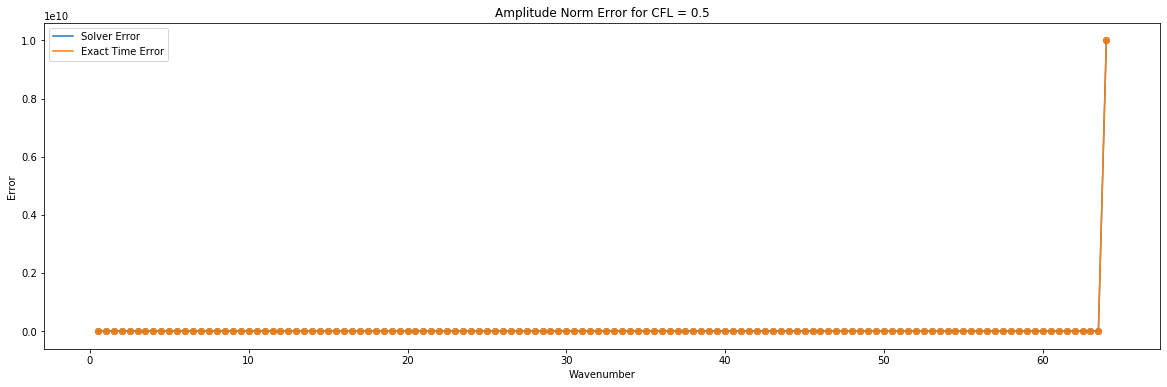

In [8]:
title = 'Amplitude Norm Error for CFL = ' + str(CFL)
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ks, solvError, label = 'Solver Error', color = PT.ColorDefault(0))
plt.scatter(ks, solvError, color = PT.ColorDefault(0))
plt.plot(ks, exTimeError, label = 'Exact Time Error', color = PT.ColorDefault(1))
plt.scatter(ks, exTimeError, color = PT.ColorDefault(1))
plt.title(title)
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
# plt.ylim(-1, 1.1)
# plt.yscale('log')
plt.show()

In [9]:
# def SolverAmpTheoretical(omega, RK, deriv, CFL):
#     nh_max = omega.nh_max
#     ks = np.arange((nh_max / 2) + 1)
#     theta = (2 * np.pi * ks) / nh_max
#     if (deriv == 'U'):
#         print('Upwind', RK)
#         x = CFL * (1 - np.exp(-1j * theta))
#     else:
#         x = 0.5 * CFL * (np.exp(1j * theta) - np.exp(-1j * theta))
#     coefs = np.arange(RK + 1)[::-1]
#     coefs = sp.special.factorial(coefs)**-1
#     coefs[1::2] = -coefs[1::2]
#     p = np.poly1d(coefs)
#     amps = p(x)
#     return ks, amps

In [10]:
ksT, amps = TT.SolverAmpTheoretical(omega, RK, deriv, CFL)


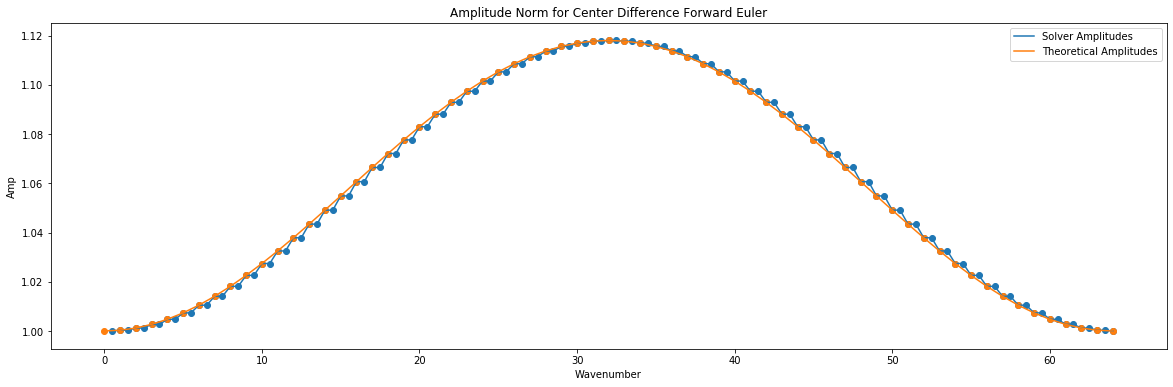

In [11]:
numPoints, font, X, savePath = PT.UsefulPlotVals()
title1 = 'Amplitude Norm for '
if (deriv == 'U'):
    title2 = 'Upwind '
    saveName1 = 'UW'
else:
    title2 = 'Center Difference '
    saveName1 = 'CD'
if (RK == 1):
    title3 = 'Forward Euler'
else:
    if (RK == 2):
        title3 = 'Midpoint Method'
    else:
        title3 = 'Fourth-Order Runge-Kutta'
saveName = savePath + saveName1 + 'RK' + str(RK) + '.png'
title = title1 + title2 + title3
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ks, solvNorm, label = 'Solver Amplitudes', color = PT.ColorDefault(0))
plt.scatter(ks, solvNorm, color = PT.ColorDefault(0))
plt.plot(ksT, abs(amps), label = 'Theoretical Amplitudes', color = PT.ColorDefault(1))
plt.scatter(ksT, abs(amps), color = PT.ColorDefault(1))
# plt.plot(ksT, np.imag(amps), label = 'Imaginary Amplitudes', color = PT.ColorDefault(2))
# plt.scatter(ksT, np.imag(amps), color = PT.ColorDefault(2))
# plt.plot(ks, exTimeError, label = 'Exact Time Error', color = PT.ColorDefault(1))
# plt.scatter(ks, exTimeError, color = PT.ColorDefault(1))
plt.title(title)
plt.xlabel('Wavenumber')
plt.ylabel('Amp')
plt.legend()
fig.savefig(saveName, bbox_inches = 'tight', dpi = 300, transparent = True)
# plt.ylim(-10, 1000)
# plt.yscale('log')
plt.show()

In [13]:
solvTrunc = np.append(solvNorm[0], solvNorm[1::2])
norm = TT.VectorNorm(solvTrunc - abs(amps), normType = 'L2')
print('Error Norm: ', str(norm))

Error Norm:  2.3288234633381844e-15


In [ ]:
A = arange(8)
print(A)
print(A ** 2)

In [ ]:
propFCoefs, solvFCoefs, exTimeCoefs = ModeProp(omega, nt, c, CFL, deriv, RK, order)
print(np.round(solvFCoefs, 15))